# IMPORT DEPENDENCIES

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.preprocessing import LabelEncoder
import time
import shutil
import pathlib
import itertools
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.metrics import Precision, Recall, AUC
from google.colab import runtime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LOADING DATA

In [3]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
categories = ["Normal","Osteopenia", "Osteoporosis"]

In [4]:
TfDatasetsPath = '/content/drive/MyDrive/CSEN-240-Project/TfDatasets'
# TfDatasetsPath = 'TfDatasets'

In [5]:
trainDataset = tf.data.Dataset.load(TfDatasetsPath + "/trainDataset")
validDataset = tf.data.Dataset.load(TfDatasetsPath + "/validDataset")
testDataset = tf.data.Dataset.load(TfDatasetsPath + "/testDataset")

In [6]:
def augment(image, label):
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    return image, label

In [7]:
augmentedDataset = trainDataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
trainDataset = trainDataset.concatenate(augmentedDataset)

In [8]:
len(trainDataset), len(validDataset), len(testDataset)

(6048, 378, 378)

In [9]:
trainDataset = trainDataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
validDataset = validDataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
testDataset = testDataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
trainDataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [11]:
metrics = [Precision(), Recall(), AUC(), 'accuracy']

# EfficientNetV2M Model

In [12]:
base_model = tf.keras.applications.EfficientNetV2M(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(3, activation="softmax")(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=metrics)

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


# TRAINING

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 24)   │            648 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 24)   │             96 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 24)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 112, 112, 24)   │          5,184 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 112, 112, 24)   │             96 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 112, 112, 24)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_add (Add)         │ (None, 112, 112, 24)   │              0 │ block1a_project_activ… │
│                           │                        │                │ stem_activation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 112, 112, 24)   │          5,184 │ block1a_add[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 112, 112, 24)   │             96 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 112, 112, 24)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 112, 112, 24)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 112, 112, 24)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_add[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1c_project_conv 

 Total params: 53,941,431 (205.77 MB)

 Trainable params: 789,507 (3.01 MB)

 Non-trainable params: 53,151,924 (202.76 MB)

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True)

In [15]:
# Defining The ReduceLRonPlateau Callback
reduceLRCallback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.8, # How much to improve the learning rate -> LR = LR*factor
    patience=3,
    verbose=1,
    mode='max',
    min_delta=0.0001, # Change in metric below this delta is considered as no change
    cooldown=0, # Number of epochs to wait before resuming normal operation after lr has been improved
    min_lr=0 # Learning Rate won't go below this
)

In [16]:
history = model.fit(trainDataset,
                        validation_data=validDataset,
                        epochs=250,
                        callbacks=[early_stopping, reduceLRCallback],
                        verbose=1)

Epoch 1/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 143s 282ms/step - accuracy: 0.3374 - auc: 0.4970 - loss: 1.9357 - precision: 0.3350 - recall: 0.2858 - val_accuracy: 0.3704 - val_auc: 0.5399 - val_loss: 1.2960 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.3527 - auc: 0.5221 - loss: 1.6947 - precision: 0.3534 - recall: 0.2916 - val_accuracy: 0.3201 - val_auc: 0.5326 - val_loss: 1.2522 - val_precision: 0.3333 - val_recall: 0.0053 - learning_rate: 1.0000e-04
Epoch 3/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.3522 - auc: 0.5223 - loss: 1.6219 - precision: 0.3509 - recall: 0.2780 - val_accuracy: 0.3228 - val_auc: 0.5187 - val_loss: 1.1411 - val_precision: 0.3571 - val_recall: 0.0265 - learning_rate: 1.0000e-04
Epoch 4/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.3593 - auc: 0.5206 - loss: 1.5978 - precision: 0.3676 - recall: 0.2888 - val_accuracy: 0.3519 - val_auc: 

# FINE-TUNING

In [17]:
base_model.trainable = True

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss="categorical_crossentropy", metrics=metrics)

In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 24)   │            648 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 24)   │             96 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 24)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 112, 112, 24)   │          5,184 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 112, 112, 24)   │             96 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 112, 112, 24)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_add (Add)         │ (None, 112, 112, 24)   │              0 │ block1a_project_activ… │
│                           │                        │                │ stem_activation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 112, 112, 24)   │          5,184 │ block1a_add[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 112, 112, 24)   │             96 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 112, 112, 24)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 112, 112, 24)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 112, 112, 24)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_add[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1c_project_conv 

 Total params: 53,941,431 (205.77 MB)

 Trainable params: 53,647,863 (204.65 MB)

 Non-trainable params: 293,568 (1.12 MB)

In [20]:
history = model.fit( trainDataset,
                         validation_data=validDataset,
                         epochs=250,
                         callbacks=[early_stopping, reduceLRCallback],
                         verbose=1)

Epoch 1/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 271s 237ms/step - accuracy: 0.4169 - auc: 0.5891 - loss: 1.5141 - precision: 0.4288 - recall: 0.3103 - val_accuracy: 0.5529 - val_auc: 0.7558 - val_loss: 0.9325 - val_precision: 0.5768 - val_recall: 0.4471 - learning_rate: 5.0000e-05
Epoch 2/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - accuracy: 0.5527 - auc: 0.7361 - loss: 1.1678 - precision: 0.5657 - recall: 0.5135 - val_accuracy: 0.6772 - val_auc: 0.8187 - val_loss: 0.8846 - val_precision: 0.6844 - val_recall: 0.6138 - learning_rate: 5.0000e-05
Epoch 3/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - accuracy: 0.6120 - auc: 0.7932 - loss: 1.0124 - precision: 0.6299 - recall: 0.5800 - val_accuracy: 0.7090 - val_auc: 0.8573 - val_loss: 0.7762 - val_precision: 0.7171 - val_recall: 0.6772 - learning_rate: 5.0000e-05
Epoch 4/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - accuracy: 0.6796 - auc: 0.8468 - loss: 0.8562 - precision: 0.7029 - recall: 0.6518 - val_accuracy: 0.6984 - val_auc: 0.

# PLOTS

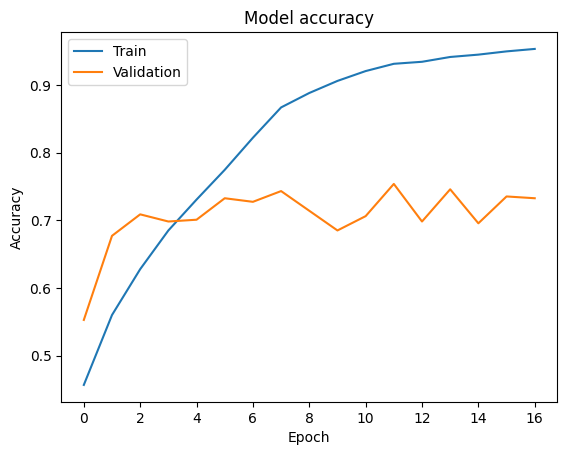

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

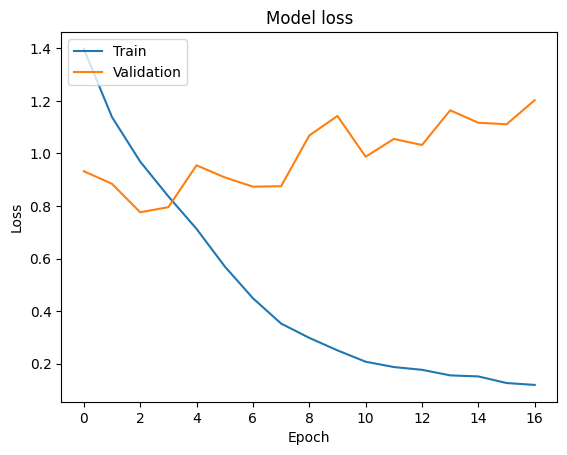

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [23]:
valid_labels = []
for xBatch, yBatch in validDataset:
    valid_labels.extend(np.argmax(yBatch, axis=1))
predictions = model.predict(validDataset)
predicted_classes = np.argmax(predictions, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step


In [24]:
def ppo_loss(y_true, y_pred):
    epsilon = 0.2
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
    selected_probs = tf.reduce_sum(y_pred * y_true_one_hot, axis=-1)
    old_selected_probs = tf.reduce_sum(tf.stop_gradient(y_pred) * y_true_one_hot, axis=-1)
    ratio = selected_probs / (old_selected_probs + 1e-10)
    clipped_ratio = tf.clip_by_value(ratio, 1 - epsilon, 1 + epsilon)
    loss = -tf.reduce_mean(tf.minimum(ratio, clipped_ratio))
    return loss

In [25]:
ppo_loss_value = ppo_loss(valid_labels, predictions)
print("\nPPO Loss on Validation Data:", ppo_loss_value.numpy())


PPO Loss on Validation Data: -0.9999995


# TESTING

In [26]:
test_labels = []
for xBatch, yBatch in testDataset:
    test_labels.extend(np.argmax(yBatch, axis=1))
predictions = model.predict(testDataset)
predicted_classes = np.argmax(predictions, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


In [27]:
report = classification_report(test_labels, predicted_classes, target_names=categories)
print(report)

              precision    recall  f1-score   support

      Normal       0.80      0.75      0.77       126
  Osteopenia       0.74      0.71      0.72       126
Osteoporosis       0.71      0.78      0.74       126

    accuracy                           0.74       378
   macro avg       0.75      0.74      0.74       378
weighted avg       0.75      0.74      0.74       378



Text(95.72222222222221, 0.5, 'True Label')

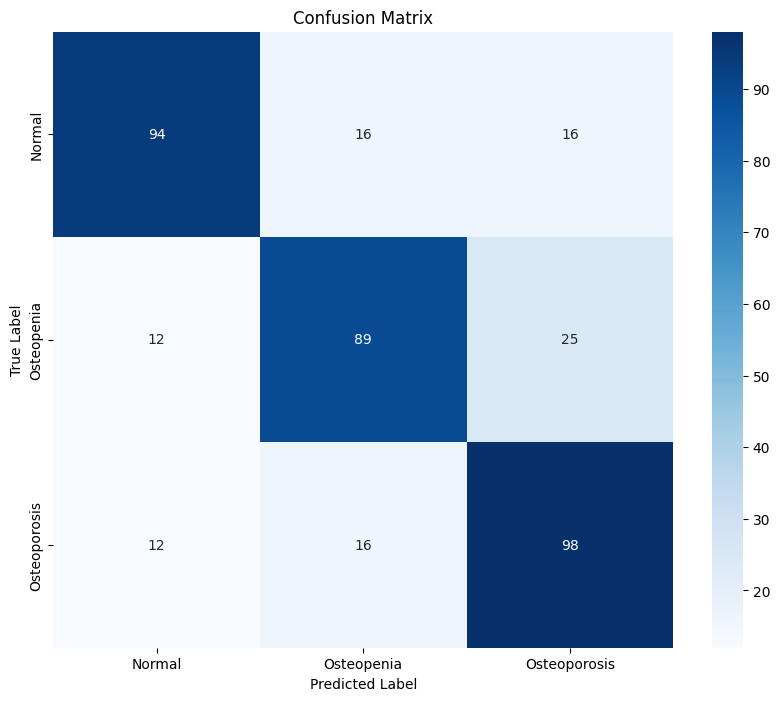

In [28]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [29]:
runtime.unassign()